In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist,mnist
import time
import pickle

In [2]:
import wandb
wandb.login()
#API Key: f659082c2b19bf3ffaaceceb36c1e280541f6b11

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yeshu183 (yeshu183-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Split validation set (10% of training data)
val_size = int(0.1 * len(x_train))
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train, y_train = x_train[val_size:], y_train[val_size:]

# Normalize inputs
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_val = x_val.reshape(x_val.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

In [ ]:
y_train

array([8, 6, 4, ..., 3, 0, 5], dtype=uint8)

In [6]:
class Optimizers:
    def __init__(self, lr=1e-3, epsilon=1e-8, beta1=0.9, beta2=0.999, rho=0.9, optimizer="adam"):
        self.lr = lr
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.rho = rho
        self.optimizer = optimizer  # Store optimizer type

        self.v, self.s, self.m = {}, {}, {}  # Optimizer state
        self.t = 0  # Time step for Adam/Nadam

    def _initialize_params(self, key, shape):
        """Initialize optimizer states for a given parameter key"""
        if key not in self.v:
            self.v[key] = np.zeros(shape)
            self.s[key] = np.zeros(shape)
            self.m[key] = np.zeros(shape)

    def step(self, w, b, dw, db, key="w"):
        """Generic function to perform an optimization step based on selected optimizer"""
        self._initialize_params(key, w.shape)
        self.t += 1  # Increment time step

        if self.optimizer == "sgd":
            w -= self.lr * dw
            b -= self.lr * db

        elif self.optimizer == "momentum":
            self.v[key] = self.beta1 * self.v[key] - self.lr * dw
            w += self.v[key]
            b -= self.lr * db

        elif self.optimizer == "nesterov":
            prev_v = self.v[key]
            self.v[key] = self.beta1 * self.v[key] - self.lr * dw
            w += -self.beta1 * prev_v + (1 + self.beta1) * self.v[key]
            b -= self.lr * db

        elif self.optimizer == "rmsprop":
            self.s[key] = self.rho * self.s[key] + (1 - self.rho) * (dw ** 2)
            w -= self.lr * dw / (np.sqrt(self.s[key]) + self.epsilon)
            b -= self.lr * db

        elif self.optimizer == "adam":
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * dw
            self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (dw ** 2)
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            s_hat = self.s[key] / (1 - self.beta2 ** self.t)
            w -= self.lr * m_hat / (np.sqrt(s_hat) + self.epsilon)
            b -= self.lr * db

        return w, b

In [7]:
class NN:
  def __init__(self,input_shape,output_shape,n_hidden_layers,h_per_layer,optimizer,activation_func="relu",loss_func="cross_entropy_loss",init_type="random",l2_reg=0):
    self.input_shape = input_shape
    self.output_shape = output_shape
    self.n_h = n_hidden_layers
    self.k = h_per_layer
    self.weights,self.biases = self.weight_init(init_type)
    self.optimizer_function = optimizer
    self.grad_weights = [0]*(self.n_h+1)
    self.grad_biases = [0]*(self.n_h+1)
    self.activation_func = activation_func
    self.loss_func = loss_func
    self.l2_reg = l2_reg
  def activation(self,x):
    if self.activation_func == "relu":
      return np.maximum(0,x)
    elif self.activation_func == "tanh":
      return np.tanh(x)
    elif self.activation_func == "sigmoid":
      return 1/(1+np.exp(-x))
  def activation_grad(self,x):
    if self.activation_func == "relu":
      return np.where(x>0,1,0)
    elif self.activation_func == "tanh":
      return 1-np.tanh(x)**2
    elif self.activation_func == "sigmoid":
      s = 1/(1+np.exp(-x))
      return s*(1-s)
  def softmax(self,x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)
  def one_hot(self,y):
    ohe = np.zeros((len(y), self.output_shape))
    for i in range(len(y)):
      ohe[i][y[i]] = 1
    return ohe
  def loss(self,y_hat,y_true):
    if self.loss_func == "cross_entropy_loss":
      y_hat = np.array(y_hat)
      y_true = np.array(y_true)
      epsilon = 1e-10  # Prevent log(0)
      return -np.sum(y_true * np.log(y_hat + epsilon)) / y_hat.shape[0]
    elif self.loss_func == "squared_error":
      diff = y_hat - y_true
      squared_diff = diff**2
      mse = np.mean(squared_diff)
      return mse
  def accuracy(self,y_hat,y_true):
    return np.sum(y_hat==y_true)/len(y_true)
  def weight_init(self, init_type="random"):
    weights = []
    biases = []
    if init_type == "random":
        weights.append(np.random.randn(self.input_shape, self.k))
        biases.append(np.random.randn(self.k, 1))
        for i in range(self.n_h - 1):
            weights.append(np.random.randn(self.k, self.k))
            biases.append(np.random.randn(self.k, 1))
        weights.append(np.random.randn(self.k, self.output_shape))
        biases.append(np.random.randn(self.output_shape, 1))
    elif init_type == "xavier":
        # Xavier Initialization
        weights.append(np.random.randn(self.input_shape, self.k) * np.sqrt(2 / (self.input_shape + self.k)))
        biases.append(np.zeros((self.k, 1)))  # Biases are usually initialized to 0
        for i in range(self.n_h - 1):
            weights.append(np.random.randn(self.k, self.k) * np.sqrt(2 / (self.k + self.k)))
            biases.append(np.zeros((self.k, 1)))
        weights.append(np.random.randn(self.k, self.output_shape) * np.sqrt(2 / (self.k + self.output_shape)))
        biases.append(np.zeros((self.output_shape, 1)))
    return weights, biases

  def update_parameters(self):
    for i in range(len(self.weights)):
      grad_w = np.array(self.grad_weights[i])
      grad_b = np.array(self.grad_biases[i])
      self.weights[i], self.biases[i] = self.optimizer_function.step(
              self.weights[i], self.biases[i],grad_w,grad_b,key=f"layer_{i}")

  def forward(self,x):
    a_list = [0]*(self.n_h+2)
    h_list = [0]*(self.n_h+2)
    h = x.T
    h_list[0] = h
    for i in range(self.n_h):
      a_list[i+1] = np.dot(self.weights[i].T,h_list[i])+self.biases[i] #biases are broadcasted
      h_list[i+1] = self.activation(a_list[i+1])
    a_list[self.n_h+1] = np.dot(self.weights[self.n_h].T,h_list[self.n_h])+self.biases[self.n_h]
    y_hat = self.softmax(a_list[self.n_h+1]).T
    h_list[self.n_h+1] = y_hat
    return a_list,h_list
  def backward(self,a_list,h_list,y):
    a_grad_list = [0]*(self.n_h+2)
    h_grad_list = [0]*(self.n_h+2)
    y_hat = h_list[self.n_h+1]
    if self.loss_func == "cross_entropy_loss": #gradient wrt output layer
      a_grad = (y_hat - self.one_hot(y)).T
    elif self.loss_func == "squared_error":
      #a_grad = (y_hat - self.one_hot(y)).T
      a_grad = (2*(y_hat - self.one_hot(y))*y_hat*(1-y_hat)).T #must be changed appropriately
    a_grad_list[-1] = a_grad/y_hat.shape[0]
    for k in range(self.n_h,-1,-1): # gradient wrt hiddden layers
      h_grad = np.dot(self.weights[k],a_grad_list[k+1])
      h_grad_list[k] = h_grad
      a_grad = np.multiply(h_grad,self.activation_grad(a_list[k]))
      a_grad_list[k] = a_grad
      self.grad_weights[k] = np.dot(a_grad_list[k+1],h_list[k].T).T + + self.l2_reg * self.weights[k] #gradients wrt parameters
      self.grad_biases[k] = np.sum(a_grad_list[k+1],axis=1, keepdims=True)
  def predict(self,x):
    a_list,h_list = self.forward(x)
    return np.argmax(h_list[self.n_h+1],axis=0)
  def train(self,x_train,y_train,x_val,y_val,epochs=10,batch_size=32):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    for i in range(epochs):
      start = time.time()
      indices = np.arange(len(x_train))
      np.random.shuffle(indices)
      per_epoch_loss = []
      per_epoch_acc = []
      for j in range(0,len(x_train),batch_size):
        #startf = time.time()
        batch_indices = indices[j:j+batch_size]
        x_batch = x_train[batch_indices]
        y_batch = y_train[batch_indices]
        a_list_train,h_list_train = self.forward(x_batch) # forward pass
        #end_time_f = time.time()
        #startb = time.time()
        #print("forward pass done")
        self.backward(a_list_train,h_list_train,y_batch) # backward pass
        #end_time_b = time.time()
        #starto = time.time()
        #print("backward pass done")
        self.update_parameters()
        #self.optimizer_function(lr=lr) # updating weights
        #end_time_o = time.time()
        #print("optimizer done")
        y_hat = h_list_train[self.n_h+1]
        per_epoch_loss.append(self.loss(y_hat,self.one_hot(y_batch)))
        per_epoch_acc.append(self.accuracy(np.argmax(np.array(y_hat),axis=1),y_batch))
      train_loss = np.mean(per_epoch_loss)
      train_acc = np.mean(per_epoch_acc)
      train_loss_list.append(train_loss)
      train_acc_list.append(train_acc)
      #print(f"Epoch: {i+1} | Batch: {j+1}/{len(x_train)} | f_time: {(end_time_f-startf): .6f} | b_time:{(end_time_b-startb): .6f} | o_time:{(end_time_o-starto): .6f}")
      #print("Train Loss: ",train_loss,"Train Accuracy: ",train_acc)
      a_list_val,h_list_val = self.forward(x_val)
      y_hat_val = h_list_val[self.n_h+1]
      val_loss = self.loss(y_hat_val,self.one_hot(y_val))
      val_acc = self.accuracy(np.argmax(np.array(y_hat_val),axis=1),y_val)
      val_loss_list.append(val_loss)
      val_acc_list.append(val_acc)
      end = time.time()
      # Log metrics
      wandb.log({
          "train_loss": train_loss,
          "train_acc": train_acc,
          "val_loss": val_loss,
          "val_acc": val_acc,
          "epoch": i+1
      })
      print(f"Epoch: {i+1} | Time: {(end-start):.2f} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")
    return train_loss_list,train_acc_list,val_loss_list,val_acc_list

In [ ]:
wandb.finish()
wandb.init(project="Example_run")
# Hyperparameters
num_hid_layers = 3 #3,4,5
hid_layer_size = 64  # Changeable number of layers
weight_init = 'xavier'  # Options: 'random', 'xavier'
activation = 'relu'  # Options: 'sigmoid', 'tanh', 'relu'
l2_reg = 0.05  # L2 regularization strength
lr = 1e-3  # Options: 1e-3, 1e-4
batch_size = 64  # Options: 16, 32, 64
epochs = 3  # Options: 5, 10
optimizer_func = 'sgd'  # Options: 'sgd', 'momentum', 'nesterov', 'rmsprop', 'adam'
loss_func = "squared_error"  # Options: 'cross_entropy_loss', 'squared_error'
# self,input_shape,output_shape,n_hidden_layers,h_per_layer,activation_func="ReLU",loss_func="cross_entropy_loss"
# Initialize and train the model
optimizer = Optimizers(lr=lr, beta1=0.9, beta2=0.999, rho=0.9, optimizer=optimizer_func)
nn = NN(input_shape=784,output_shape=10,n_hidden_layers=num_hid_layers, h_per_layer=hid_layer_size, activation_func=activation, init_type=weight_init, loss_func=loss_func,l2_reg=l2_reg,optimizer=optimizer)
train_loss_list,train_acc_list,val_loss_list,val_acc_list = nn.train(x_train, y_train, x_val, y_val, epochs=epochs,batch_size=batch_size)
wandb.finish()

Epoch: 1 | Time: 4.85 | Train Loss: 0.0896 | Train Accuracy: 0.1234 | Val Loss: 0.0887 | Val Accuracy: 0.1583
Epoch: 2 | Time: 2.98 | Train Loss: 0.0881 | Train Accuracy: 0.1972 | Val Loss: 0.0875 | Val Accuracy: 0.2353
Epoch: 3 | Time: 2.59 | Train Loss: 0.0871 | Train Accuracy: 0.2588 | Val Loss: 0.0865 | Val Accuracy: 0.2980


epoch,▁▅█
train_acc,▁▅█
train_loss,█▄▁
val_acc,▁▅█
val_loss,█▄▁
epoch,3
train_acc,0.25881
train_loss,0.08712
val_acc,0.298
val_loss,0.08653


In [ ]:
# Initialize Weights & Biases (wandb)
wandb.finish()
best_val_acc = 0

# nn = NN(input_shape=784,output_shape=10,n_hidden_layers=num_hid_layers, h_per_layer=hid_layer_size, activation_func=activation, init_type=weight_init, loss_func=loss_func,l2_reg=l2_reg)
# train_loss_list,train_acc_list,val_loss_list,val_acc_list = nn.train(x_train, y_train, x_val, y_val, epochs=epochs,lr=lr,batch_size=batch_size)

# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Options: grid, random, bayes
    'metric': {'name': 'final_val_acc', 'goal': 'maximize'},
    'parameters': {
        'loss_func': {'values': ['cross_entropy_loss']},#, 'squared_error'
        'epochs': {'values': [10]},
        'num_hid_layers': {'values': [3, 4]},
        'hid_layer_size': {'values': [64,128]},
        'lr': {'values': [1e-3]},
        'weight_init': {'values': ['xavier']},
        'activation': {'values': ['tanh']},
        'l2_reg': {'values': [0]},
        'batch_size': {'values': [64]},
        'optimizer_func': {'values': ['adam']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="New Sweep")

def train_sweep():
    global best_val_acc
    wandb.init(project="New Sweep")
    config = wandb.config
    wandb.run.name = f"e_{config.epochs}_hl_{config.num_hid_layers}_nhpl_{config.hid_layer_size}_bs_{config.batch_size}_init_{config.weight_init}_ac_{config.activation}_op_{config.optimizer_func}_lo_{config.loss_func}"
    optimizer = Optimizers(lr=config.lr, beta1=0.9, beta2=0.999, rho=0.9, optimizer=config.optimizer_func)
    nn = NN(
        input_shape=784,
        n_hidden_layers=config.num_hid_layers,
        h_per_layer=config.hid_layer_size,
        activation_func=config.activation,
        init_type=config.weight_init,
        l2_reg=config.l2_reg,
        optimizer=optimizer,
        loss_func=config.loss_func,
        output_shape=10
    )

    train_loss_list,train_acc_list,val_loss_list,val_acc_list = nn.train(x_train, y_train, x_val, y_val, epochs=config.epochs, batch_size=config.batch_size)

    a_list_val,h_list_val = nn.forward(x_val)
    y_hat_val = h_list_val[nn.n_h+1]
    a_list_test,h_list_test = nn.forward(x_test)
    y_hat_test = h_list_test[nn.n_h+1]
    final_val_loss = nn.loss(y_hat_val,nn.one_hot(y_val))
    final_val_acc = nn.accuracy(np.argmax(np.array(y_hat_val),axis=1),y_val)
    final_test_loss = nn.loss(y_hat_test,nn.one_hot(y_test))
    final_test_acc = nn.accuracy(np.argmax(np.array(y_hat_test),axis=1),y_test)
    wandb.log({"train_loss": train_loss_list})
    wandb.log({"train_acc": train_acc_list})
    wandb.log({"val_loss": val_loss_list})
    wandb.log({"val_acc": val_acc_list})
    wandb.log({"final_val_loss": final_val_loss})
    wandb.log({"final_val_acc": final_val_acc})
    print(f"Test Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_acc:.4f}")
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        with open("best_model.pkl", "wb") as f:
            pickle.dump(nn, f)  # Save the entire model object
        wandb.save("best_model.pkl")  # Save to W&B cloud storage
        print("Best model updated!")

wandb.agent(sweep_id, function=train_sweep,count=100)
wandb.finish()

Create sweep with ID: dw22ve2e
Sweep URL: https://wandb.ai/yeshu183-indian-institute-of-technology-madras/New%20Sweep/sweeps/dw22ve2e


wandb: Agent Starting Run: 5b8z0bp7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 3
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 4.34 | Train Loss: 0.2974 | Train Accuracy: 0.9125 | Val Loss: 0.1472 | Val Accuracy: 0.9570
Epoch: 2 | Time: 8.45 | Train Loss: 0.1291 | Train Accuracy: 0.9609 | Val Loss: 0.1100 | Val Accuracy: 0.9665
Epoch: 3 | Time: 4.60 | Train Loss: 0.0929 | Train Accuracy: 0.9713 | Val Loss: 0.1087 | Val Accuracy: 0.9637
Epoch: 4 | Time: 4.38 | Train Loss: 0.0714 | Train Accuracy: 0.9783 | Val Loss: 0.0964 | Val Accuracy: 0.9715
Epoch: 5 | Time: 7.87 | Train Loss: 0.0580 | Train Accuracy: 0.9821 | Val Loss: 0.0895 | Val Accuracy: 0.9733
Epoch: 6 | Time: 4.65 | Train Loss: 0.0465 | Train Accuracy: 0.9853 | Val Loss: 0.0895 | Val Accuracy: 0.9755
Epoch: 7 | Time: 8.82 | Train Loss: 0.0384 | Train Accuracy: 0.9878 | Val Loss: 0.1008 | Val Accuracy: 0.9717
Epoch: 8 | Time: 4.64 | Train Loss: 0.0319 | Train Accuracy: 0.9899 | Val Loss: 0.0946 | Val Accuracy: 0.9730
Epoch: 9 | Time: 7.93 | Train Loss: 0.0269 | Train Accuracy: 0.9921 | Val Loss: 0.1307 | Val Accuracy: 0.9675
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▅▄▆▇█▇▇▅▆
val_loss,█▃▃▂▁▁▂▂▆▃
epoch,10
final_val_acc,0.9705
final_val_loss,0.10394


wandb: Agent Starting Run: 9v8rbcxa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 8.76 | Train Loss: 0.2849 | Train Accuracy: 0.9150 | Val Loss: 0.1363 | Val Accuracy: 0.9603
Epoch: 2 | Time: 5.51 | Train Loss: 0.1258 | Train Accuracy: 0.9618 | Val Loss: 0.1083 | Val Accuracy: 0.9672
Epoch: 3 | Time: 8.76 | Train Loss: 0.0873 | Train Accuracy: 0.9732 | Val Loss: 0.0957 | Val Accuracy: 0.9703
Epoch: 4 | Time: 5.33 | Train Loss: 0.0698 | Train Accuracy: 0.9786 | Val Loss: 0.0907 | Val Accuracy: 0.9727
Epoch: 5 | Time: 8.46 | Train Loss: 0.0562 | Train Accuracy: 0.9821 | Val Loss: 0.1086 | Val Accuracy: 0.9688
Epoch: 6 | Time: 5.79 | Train Loss: 0.0456 | Train Accuracy: 0.9855 | Val Loss: 0.0961 | Val Accuracy: 0.9727
Epoch: 7 | Time: 8.79 | Train Loss: 0.0384 | Train Accuracy: 0.9882 | Val Loss: 0.1147 | Val Accuracy: 0.9697
Epoch: 8 | Time: 5.88 | Train Loss: 0.0345 | Train Accuracy: 0.9893 | Val Loss: 0.1020 | Val Accuracy: 0.9702
Epoch: 9 | Time: 8.65 | Train Loss: 0.0286 | Train Accuracy: 0.9912 | Val Loss: 0.0990 | Val Accuracy: 0.9752
Epoch: 10 

epoch,▁▂▃▃▄▅▆▆▇█
final_val_acc,▁
final_val_loss,▁
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▄▆▇▅▇▅▆█▆
val_loss,█▄▂▁▄▂▅▃▂▃
epoch,10
final_val_acc,0.97117
final_val_loss,0.10568


wandb: Agent Starting Run: jaibbp6g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	loss_func: cross_entropy_loss
wandb: 	lr: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer_func: adam
wandb: 	weight_init: xavier


Epoch: 1 | Time: 14.94 | Train Loss: 0.2611 | Train Accuracy: 0.9219 | Val Loss: 0.1327 | Val Accuracy: 0.9603
Epoch: 2 | Time: 14.94 | Train Loss: 0.1181 | Train Accuracy: 0.9637 | Val Loss: 0.1037 | Val Accuracy: 0.9682
Epoch: 3 | Time: 14.10 | Train Loss: 0.0829 | Train Accuracy: 0.9744 | Val Loss: 0.0987 | Val Accuracy: 0.9730
Epoch: 4 | Time: 14.13 | Train Loss: 0.0598 | Train Accuracy: 0.9809 | Val Loss: 0.0935 | Val Accuracy: 0.9708
Epoch: 5 | Time: 14.63 | Train Loss: 0.0488 | Train Accuracy: 0.9846 | Val Loss: 0.0967 | Val Accuracy: 0.9730


In [ ]:
print(wandb.Api().default_entity)

yeshu183-indian-institute-of-technology-madras


In [ ]:

# Connect to W&B
api = wandb.Api()

# Replace with your project name
project_name = "New Sweep"
entity_name = wandb.Api().default_entity

# Get all runs
runs = api.runs(f"{entity_name}/{project_name}")

# Find the best run based on `final_val_acc`
best_run = max(runs, key=lambda run: run.summary.get("final_val_acc", 0))

print(f"Best run ID: {best_run.id}, Accuracy: {best_run.summary.get('final_val_acc', 0)}")

# Download the best model
best_run.file("best_model.pkl").download(replace=True)
print("Best model downloaded successfully!")

# Load the saved model
with open("best_model.pkl", "rb") as f:
    best_model = pickle.load(f)

print("Best model loaded successfully!")


Best run ID: 09qrj7km, Accuracy: 0.8916666666666667
Best model downloaded successfully!
Best model loaded successfully!


## Test accuracy calculation

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Initialize W&B for testing
wandb.finish()
wandb.init(project=project_name, entity=entity_name, force=True)
wandb.run.name = "Best Model Evaluation"
wandb.run.save()
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle_boot"
]
# Run inference on the test set
a_list_test, h_list_test = best_model.forward(x_test)
y_hat_test = h_list_test[best_model.n_h+1]

# Compute test loss and accuracy
final_test_loss = best_model.loss(y_hat_test, best_model.one_hot(y_test))
final_test_acc = best_model.accuracy(np.argmax(np.array(y_hat_test), axis=1), y_test)

print(f"Test Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_acc:.4f}")
cm = confusion_matrix(y_test, np.argmax(np.array(y_hat_test),axis=1))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Log results and confusion matrix
wandb.log({
    "test_loss": final_test_loss,
    "test_acc": final_test_acc,
    "confusion_matrix": sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues")
})

wandb.finish()


Test Loss: 0.3444, Test Accuracy: 0.8824


/usr/local/lib/python3.11/dist-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



test_acc,▁
test_loss,▁
test_acc,0.8824
test_loss,0.34438


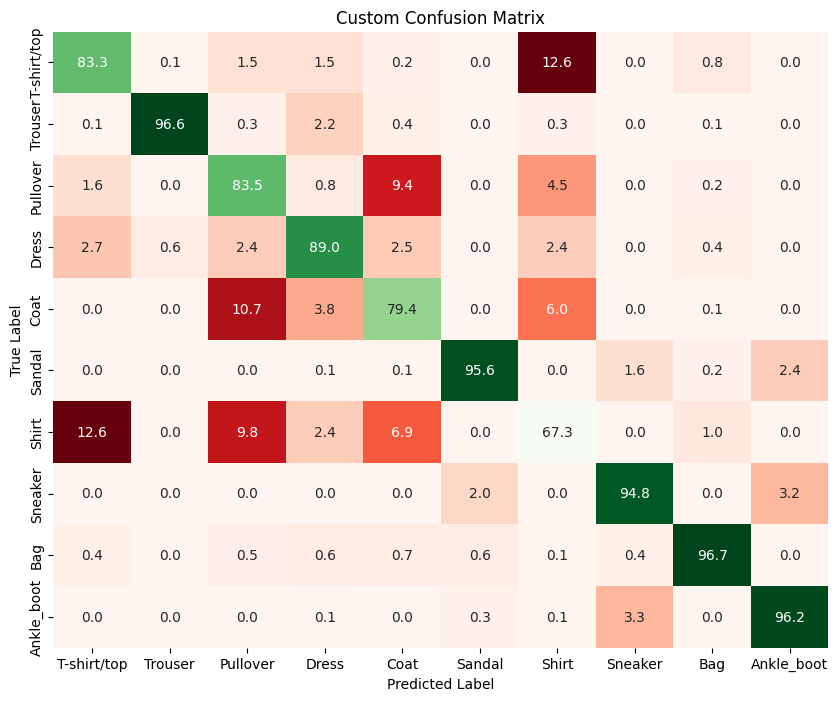

In [ ]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize Wandb
wandb.init(project="fashion-mnist", name="custom-confusion-matrix")

# Compute confusion matrix
mask = np.eye(len(cm), dtype=bool)
cm = confusion_matrix(y_test, np.argmax(np.array(y_hat_test),axis=1))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Greens",mask=~mask,xticklabels=class_labels,yticklabels=class_labels,cbar=False)
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Reds",mask=mask,xticklabels=class_labels,yticklabels=class_labels,cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Custom Confusion Matrix")

# Save the figure
plt.savefig("confusion_matrix.png", bbox_inches="tight")
wandb.log({"Custom Confusion Matrix": wandb.Image("confusion_matrix.png")})

# Close wandb
wandb.finish()


Text(50.722222222222214, 0.5, 'True')

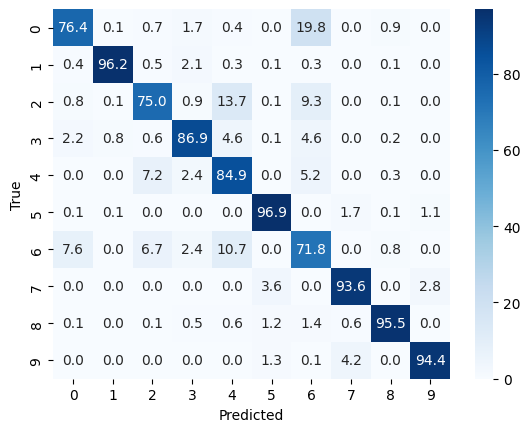

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, np.argmax(np.array(y_hat_test),axis=1))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

Text(0, 0.5, 'Acc')

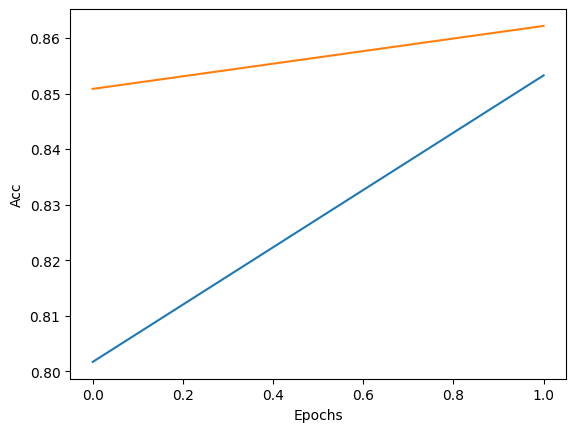

In [ ]:
plt.plot(train_acc_list)
plt.plot(val_acc_list)
#plt.plot(train_loss_list)
#plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Acc")

Text(0, 0.5, 'Loss')

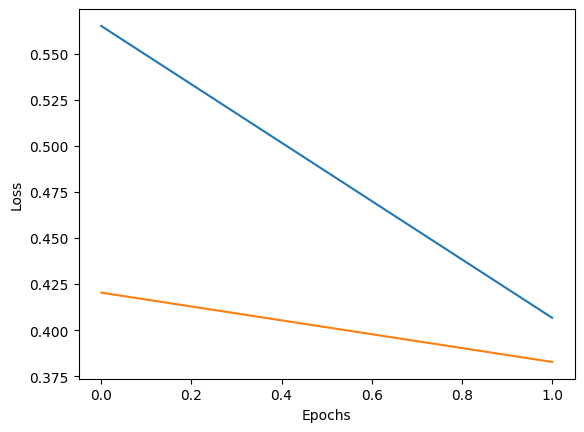

In [ ]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")